In [1]:
import numpy as np
import pandas as pd
import seaborn as sns     
sns.set()
import matplotlib.pyplot as plt
import datetime as dt

from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler    
from sklearn.metrics import r2_score

from meteostat import Point, Daily, Hourly

from IPython.display import clear_output          #For Jupyter Notebook

import warnings 
warnings.simplefilter(action='ignore', category=Warning)

pd.set_option('display.max_columns', None)
pd.set_option('display.width', 500)

In [2]:
df_raw = pd.read_csv('./data/train.csv', usecols=['pickup_datetime', 'dropoff_datetime',
       'passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', #'store_and_fwd_flag',
       'trip_duration'])

display(df_raw.sort_values('dropoff_datetime').head())
print(df_raw.shape)

,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration
404427,2016-01-01 00:01:37,2016-01-01 00:03:31,1,-73.973335,40.764072,-73.974854,40.761734,114
652463,2016-01-01 00:01:14,2016-01-01 00:05:54,1,-73.982292,40.751331,-73.991341,40.750340,280
739503,2016-01-01 00:06:12,2016-01-01 00:07:13,1,-73.935799,40.707310,-73.933060,40.709480,61
432779,2016-01-01 00:03:02,2016-01-01 00:07:25,1,-73.976860,40.683376,-73.983643,40.688866,263
713067,2016-01-01 00:01:01,2016-01-01 00:07:49,5,-73.965279,40.801041,-73.947479,40.815170,408


(1458644, 8)


In [3]:
from datetime import datetime

start = pd.to_datetime(df_raw['pickup_datetime'].min()).replace(minute=0, second=0, microsecond=0)
end = pd.to_datetime(df_raw['dropoff_datetime'].max()).replace(hour=23, minute=0, second=0, microsecond=0)

nyc = Point(40.776676, -73.971321)

data = Hourly(nyc, start, end)
df_weather = data.fetch().reset_index().fillna(0)
df_weather.tail()

,time,temp,dwpt,rhum,prcp,snow,wdir,wspd,wpgt,pres,tsun,coco
4387,2016-07-01 19:00:00,26.1,21.1,74.0,0.0,0.0,130.0,18.4,0.0,1012.1,0.0,7.0
4388,2016-07-01 20:00:00,23.9,22.2,90.0,1.5,0.0,130.0,14.8,0.0,1011.7,0.0,7.0
4389,2016-07-01 21:00:00,24.4,20.5,79.0,2.3,0.0,150.0,22.3,0.0,1010.8,0.0,7.0
4390,2016-07-01 22:00:00,23.3,20.6,85.0,2.8,0.0,260.0,16.6,0.0,1011.5,0.0,7.0
4391,2016-07-01 23:00:00,23.9,19.4,76.0,0.5,0.0,180.0,16.6,0.0,1011.0,0.0,25.0


# EDA

In [4]:
from geopy.distance import great_circle

def cal_distance(pickup_lat,pickup_long,dropoff_lat,dropoff_long):
    start_coordinates=(pickup_lat,pickup_long)
    stop_coordinates=(dropoff_lat,dropoff_long)
 
    return round(great_circle(start_coordinates,stop_coordinates).mi, 6)

## Pickup Visualization

(-74.03, -73.75)

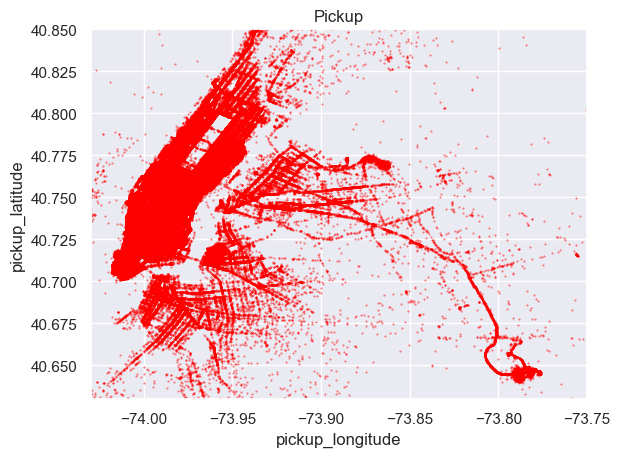

In [5]:
city_long_border = [-74.03, -73.75]
city_lat_border = [40.63,40.85]

df_raw.plot(kind='scatter', x='pickup_longitude',y='pickup_latitude',
          color='Red', s=0.2, alpha =.6)
plt.title('Pickup')

plt.ylim(city_lat_border)
plt.xlim(city_long_border)

## Dropoff Visualization

(-74.03, -73.75)

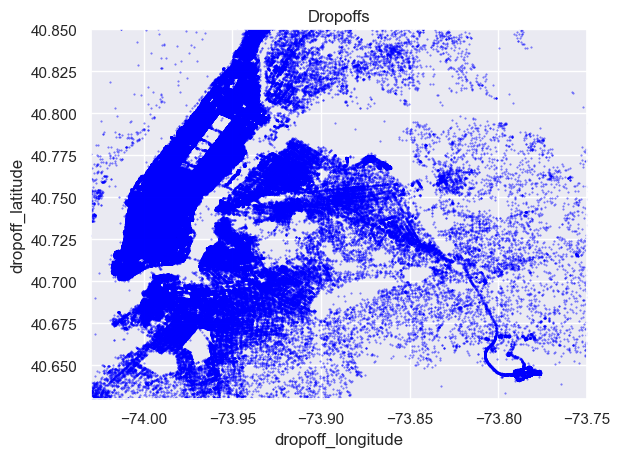

In [6]:
city_long_border = [-74.03, -73.75]
city_lat_border = [40.63,40.85]

df_raw.plot(kind='scatter', x='dropoff_longitude',y='dropoff_latitude',
          color='Blue',
          s=0.2, alpha =.6)
plt.title('Dropoffs')

plt.ylim(city_lat_border)
plt.xlim(city_long_border)

## Trip Duration

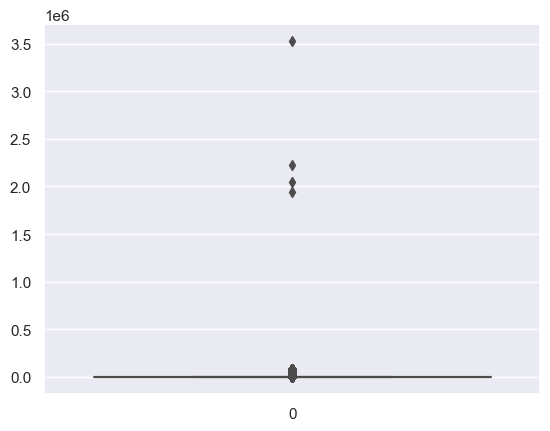

In [7]:
sns.boxplot(df_raw['trip_duration'])
plt.show()

In [8]:
print('Trips Longer than a minute', df_raw[df_raw['trip_duration']<10].shape[0])
display(df_raw[df_raw['trip_duration']<10].sample(5))

Trips Longer than a minute 1984


,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration
47391,2016-02-26 15:01:53,2016-02-26 15:02:00,1,-73.945908,40.777969,-73.945908,40.777981,7
872421,2016-03-17 12:28:39,2016-03-17 12:28:43,1,-73.937134,40.764809,-73.937202,40.764790,4
104935,2016-03-24 15:07:02,2016-03-24 15:07:10,1,-74.006828,40.719185,-74.006828,40.719181,8
450730,2016-02-09 09:42:12,2016-02-09 09:42:18,1,-73.776810,40.645454,-73.776802,40.645679,6
198271,2016-04-10 03:07:17,2016-04-10 03:07:26,1,-74.031387,40.738735,-74.031364,40.738792,9


In [9]:
print('Trips Longer than a day', df_raw[df_raw['trip_duration']>(24*60*60)].shape[0])
display(df_raw[df_raw['trip_duration']>(24*60*60)])

Trips Longer than a day 4


,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration
355003,2016-01-05 00:19:42,2016-01-27 11:08:38,1,-73.789650,40.643559,-73.956810,40.773087,1939736
680594,2016-02-13 22:38:00,2016-03-08 15:57:38,2,-73.921677,40.735252,-73.984749,40.759979,2049578
924150,2016-01-05 06:14:15,2016-01-31 01:01:07,1,-73.983788,40.742325,-73.985489,40.727676,2227612
978383,2016-02-13 22:46:52,2016-03-25 18:18:14,1,-73.783905,40.648632,-73.978271,40.750202,3526282


## Passenger Count

<Axes: xlabel='passenger_count', ylabel='count'>

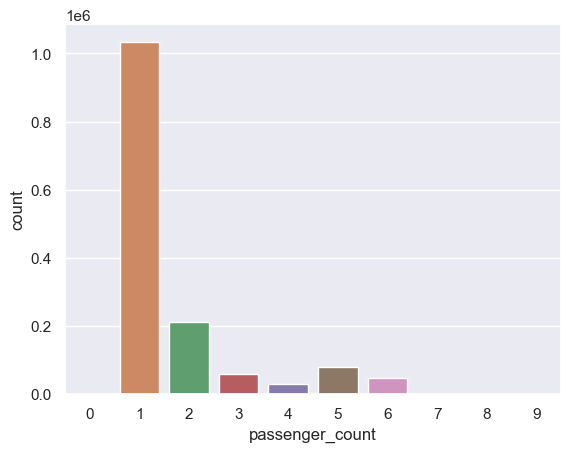

In [10]:
sns.countplot(x='passenger_count',data=df_raw)

In [11]:
print('Trips with no passengers are:', df_raw[df_raw['passenger_count'].isin([0])].shape[0])
display(df_raw[df_raw['passenger_count'].isin([0])].head())

Trips with no passengers are: 60


,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration
62744,2016-06-06 16:39:09,2016-06-07 16:30:50,0,-73.776367,40.645248,-73.776360,40.645260,85901
136519,2016-01-01 05:01:32,2016-01-01 05:01:36,0,-73.993134,40.757473,-73.993294,40.757538,4
194288,2016-02-21 01:33:52,2016-02-21 01:36:27,0,-73.946243,40.772903,-73.946770,40.774841,155
217765,2016-01-04 12:24:17,2016-01-04 13:01:48,0,-73.815224,40.700081,-73.950699,40.755222,2251
263809,2016-05-23 23:37:37,2016-05-23 23:37:45,0,-73.861633,40.705029,-73.861633,40.705029,8


In [12]:
print('Trips with more than 6 passengers are:', df_raw[df_raw['passenger_count'].isin([ 7, 8, 9])].shape[0])
display(df_raw[df_raw['passenger_count'].isin([7, 8, 9])].head())

Trips with more than 6 passengers are: 5


,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration
433304,2016-06-07 10:06:24,2016-06-07 10:06:43,7,-74.173668,40.737274,-74.173660,40.737297,19
436047,2016-06-24 08:09:21,2016-06-24 08:18:41,9,-73.710632,40.671581,-73.710632,40.671581,560
489613,2016-05-08 22:39:08,2016-05-08 22:39:23,7,-74.039482,40.715031,-74.039482,40.715019,15
824904,2016-04-23 19:46:08,2016-04-23 19:46:33,7,-73.631149,40.768551,-73.631149,40.768551,25
826064,2016-01-01 01:15:20,2016-01-01 01:17:04,8,-73.992653,40.768719,-74.041374,40.729954,104


## Distance Travelled

In [13]:
df = df_raw.copy()

df['distance'] = df.apply(lambda x: cal_distance(x['pickup_latitude'],x['pickup_longitude'],
                                                 x['dropoff_latitude'],x['dropoff_longitude']), axis=1)

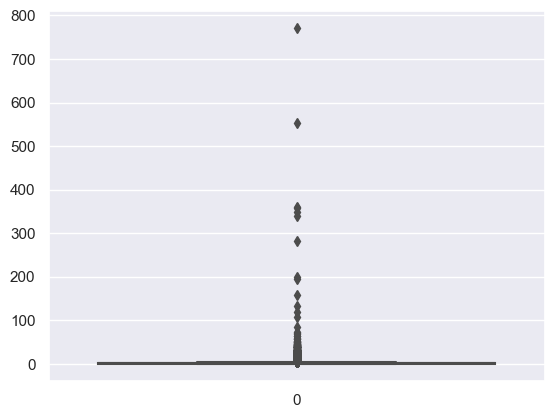

In [14]:
sns.boxplot(df['distance'])
plt.show()

In [15]:
print('Trips that travelled less than 0mi are', df[df['distance']==0].shape[0])
display(df[df['distance']==0].sample(5))

Trips that travelled less than 0mi are 5897


,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration,distance
199193,2016-04-24 14:44:22,2016-04-24 14:44:34,1,-73.985489,40.755589,-73.985489,40.755589,12,0.0
212690,2016-01-10 04:48:55,2016-01-10 04:55:32,1,-73.954666,40.821003,-73.954666,40.821003,397,0.0
526324,2016-02-06 01:15:52,2016-02-06 01:37:05,5,-73.968529,40.750648,-73.968529,40.750648,1273,0.0
929848,2016-05-09 14:29:03,2016-05-09 14:29:47,1,-73.964783,40.775524,-73.964783,40.775524,44,0.0
810803,2016-05-21 00:07:36,2016-05-21 00:07:42,1,-73.991600,40.727222,-73.991600,40.727222,6,0.0


In [16]:
print('Trips that travelled more than 100mi are', df[df['distance']>100].shape[0])
display(df[df['distance']>100].sort_values('distance').tail(5))

Trips that travelled more than 100mi are 13


,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration,distance
923793,2016-02-24 21:02:32,2016-02-24 21:25:57,1,-73.972366,40.758633,-79.553535,43.674000,1405,349.357243
1100676,2016-05-03 16:24:07,2016-05-03 17:18:34,2,-73.991325,40.750023,-79.518616,43.921028,3267,357.211544
910072,2016-02-15 18:57:32,2016-02-15 19:02:35,2,-73.989914,40.756634,-70.346077,36.398121,303,359.676760
974378,2016-01-06 20:40:52,2016-01-06 20:51:03,5,-71.799896,35.081532,-79.352837,40.436329,611,553.775552
184925,2016-05-07 18:58:53,2016-05-07 19:12:05,1,-72.809669,51.881084,-73.987228,40.750599,792,771.065993


## Average Speed

In [17]:
df['avg_speed'] = round(df['distance']/(df['trip_duration']/(60*60)), 2)

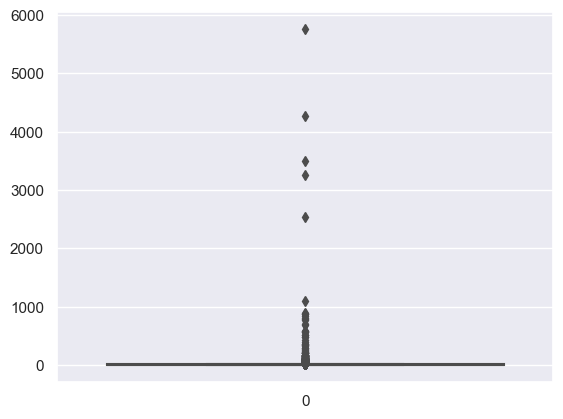

In [18]:
sns.boxplot(df['avg_speed'])
plt.show()

In [19]:
print('Trips that travelled less than 1mi/hr are', df[df['avg_speed']<1].shape[0])
display(df[df['avg_speed']<1].sample(5))

Trips that travelled less than 1mi/hr are 15359


,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration,distance,avg_speed
1039292,2016-05-01 16:28:21,2016-05-01 17:02:03,1,-73.949783,40.780403,-73.949242,40.779922,2022,0.043659,0.08
65200,2016-06-09 17:08:40,2016-06-09 17:08:46,1,-73.987289,40.672836,-73.987289,40.672836,6,0.000000,0.00
1376059,2016-03-17 09:46:32,2016-03-17 10:42:25,4,-73.988869,40.773708,-73.977974,40.771828,3353,0.584689,0.63
15013,2016-02-13 22:30:52,2016-02-13 22:31:20,1,-73.988449,40.764278,-73.988449,40.764275,28,0.000264,0.03
1189923,2016-05-19 14:47:29,2016-05-19 14:49:10,1,-73.973999,40.751884,-73.974297,40.752190,101,0.026214,0.93


In [20]:
print('Trips that travelled more than 100mi/hr are', df[df['avg_speed']>100].shape[0])
display(df[df['avg_speed']>100].sort_values('avg_speed').tail(5))

Trips that travelled more than 100mi/hr are 89


,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration,distance,avg_speed
377068,2016-04-02 20:33:19,2016-04-02 20:38:01,1,-74.007095,40.717113,-76.963242,38.946033,282,198.917215,2539.37
974378,2016-01-06 20:40:52,2016-01-06 20:51:03,5,-71.799896,35.081532,-79.352837,40.436329,611,553.775552,3262.83
184925,2016-05-07 18:58:53,2016-05-07 19:12:05,1,-72.809669,51.881084,-73.987228,40.750599,792,771.065993,3504.85
910072,2016-02-15 18:57:32,2016-02-15 19:02:35,2,-73.989914,40.756634,-70.346077,36.398121,303,359.676760,4273.39
1176337,2016-02-13 20:28:30,2016-02-13 20:28:37,1,-73.936974,40.764610,-73.789848,40.646858,7,11.206075,5763.12


## Days of the Week

In [21]:
df = df_raw.copy()

In [22]:
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])
df['dropoff_datetime'] = pd.to_datetime(df['dropoff_datetime'])

df['pickup_day']=df['pickup_datetime'].dt.day_name()
df['dropoff_day']=df['dropoff_datetime'].dt.day_name()
df['pickup_day_no']=df['pickup_datetime'].dt.weekday
df['dropoff_day_no']=df['dropoff_datetime'].dt.weekday
df['pickup_hour']=df['pickup_datetime'].dt.hour
df['dropoff_hour']=df['dropoff_datetime'].dt.hour
df['pickup_month']=df['pickup_datetime'].dt.month
df['dropoff_month']=df['dropoff_datetime'].dt.month

In [23]:
def time_of_day(x):
    if x in range(6,12):
        return '1 - Morning'
    elif x in range(12,16):
        return '2 - Afternoon'
    elif x in range(16,22):
        return '3 - Evening'
    else:
        return '4 - Late night'
    
df['pickup_timeofday']=df['pickup_hour'].apply(time_of_day)
df['dropoff_timeofday']=df['dropoff_hour'].apply(time_of_day)

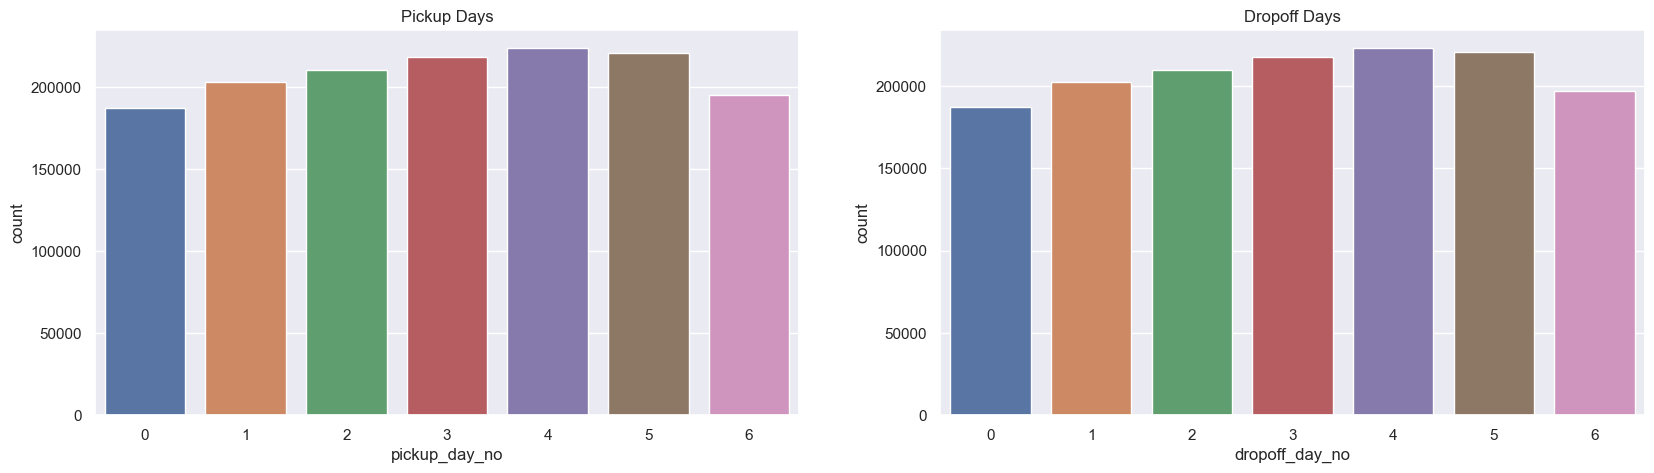

In [24]:
figure,(ax1,ax2)=plt.subplots(ncols=2,figsize=(20,5))
ax1.set_title('Pickup Days')
ax=sns.countplot(x="pickup_day_no",data=df.sort_values('pickup_day'),ax=ax1)
ax2.set_title('Dropoff Days')
ax=sns.countplot(x="dropoff_day_no",data=df.sort_values('pickup_day'),ax=ax2)

<Axes: xlabel='pickup_day_no', ylabel='trip_duration'>

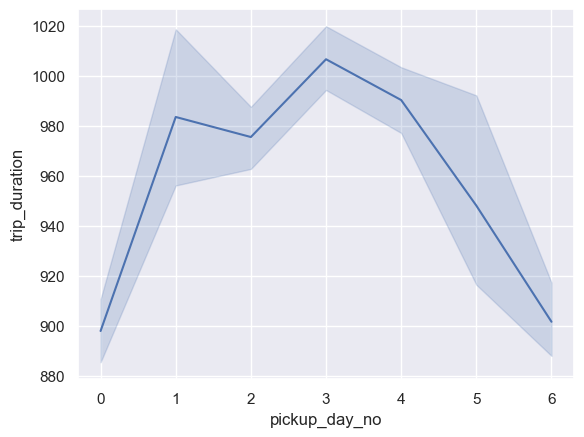

In [25]:
sns.lineplot(x='pickup_day_no', y='trip_duration', data=df)

## Trips per Hour of Day

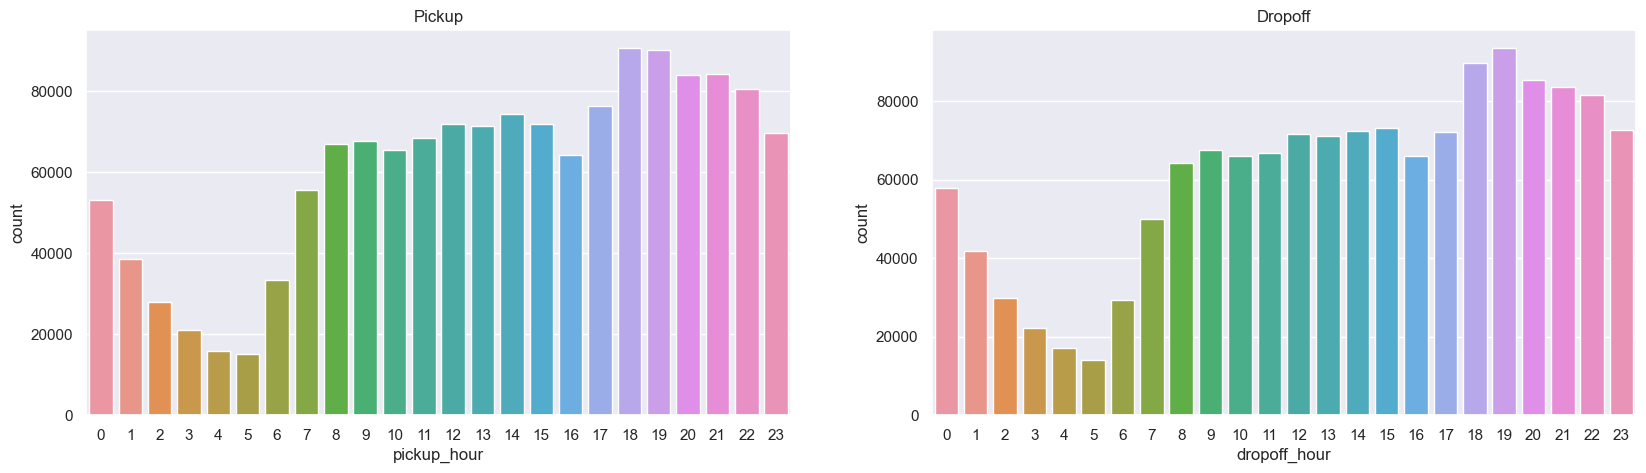

In [26]:
figure,(ax9,ax10)=plt.subplots(ncols=2,figsize=(20,5))
ax9.set_title('Pickup')
ax=sns.countplot(x="pickup_hour",data=df,ax=ax9)
ax10.set_title('Dropoff')
ax=sns.countplot(x="dropoff_hour",data=df,ax=ax10)

<Axes: xlabel='pickup_hour', ylabel='trip_duration'>

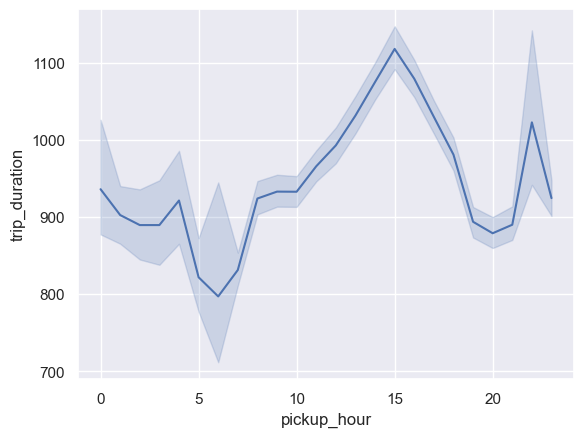

In [27]:
sns.lineplot(x='pickup_hour', y='trip_duration', data=df)

## Time of Day

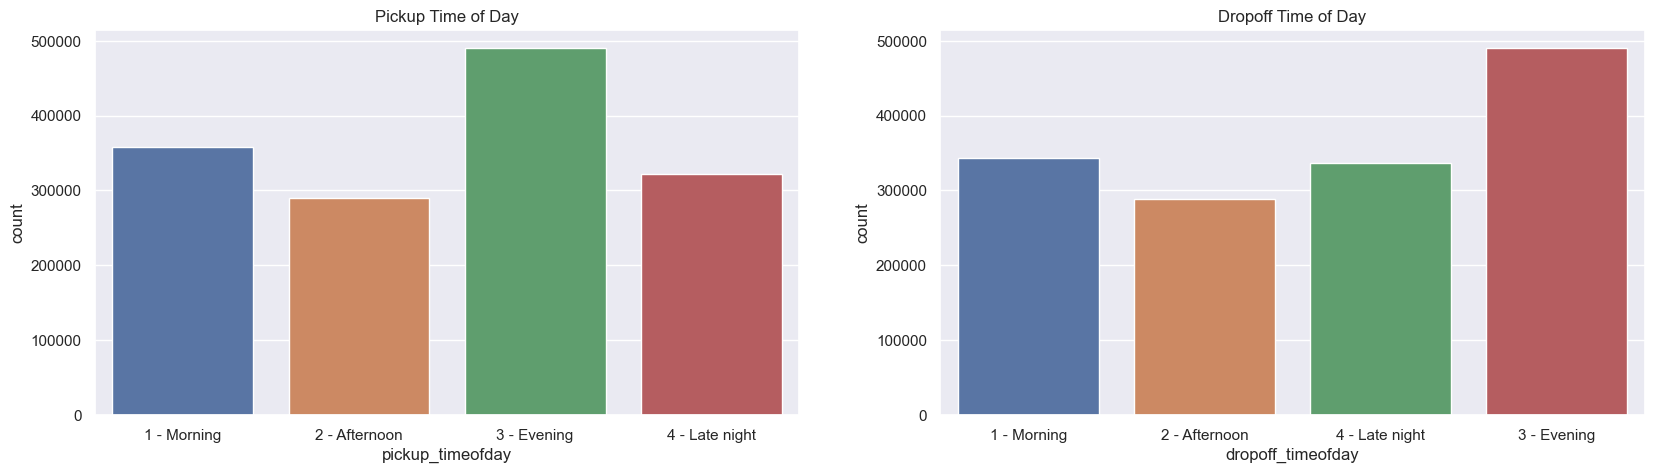

In [28]:
figure,(ax3,ax4)=plt.subplots(ncols=2,figsize=(20,5))
ax3.set_title('Pickup Time of Day')
ax=sns.countplot(x="pickup_timeofday",data=df.sort_values('pickup_timeofday'),ax=ax3)
ax4.set_title('Dropoff Time of Day')
ax=sns.countplot(x="dropoff_timeofday",data=df.sort_values('pickup_timeofday'),ax=ax4)

<Axes: xlabel='pickup_timeofday', ylabel='trip_duration'>

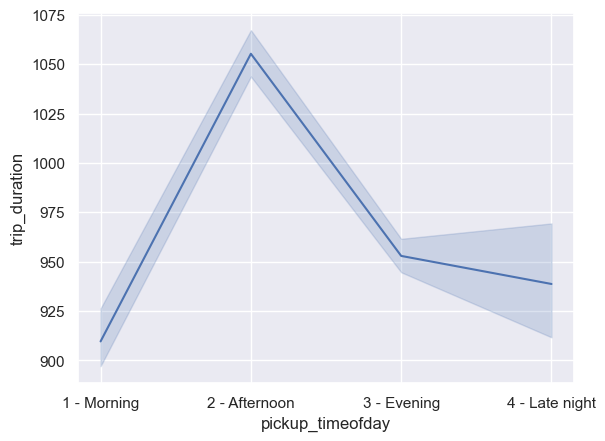

In [29]:
sns.lineplot(x='pickup_timeofday',y='trip_duration',data=df.sort_values('pickup_timeofday'))

## Time of Month

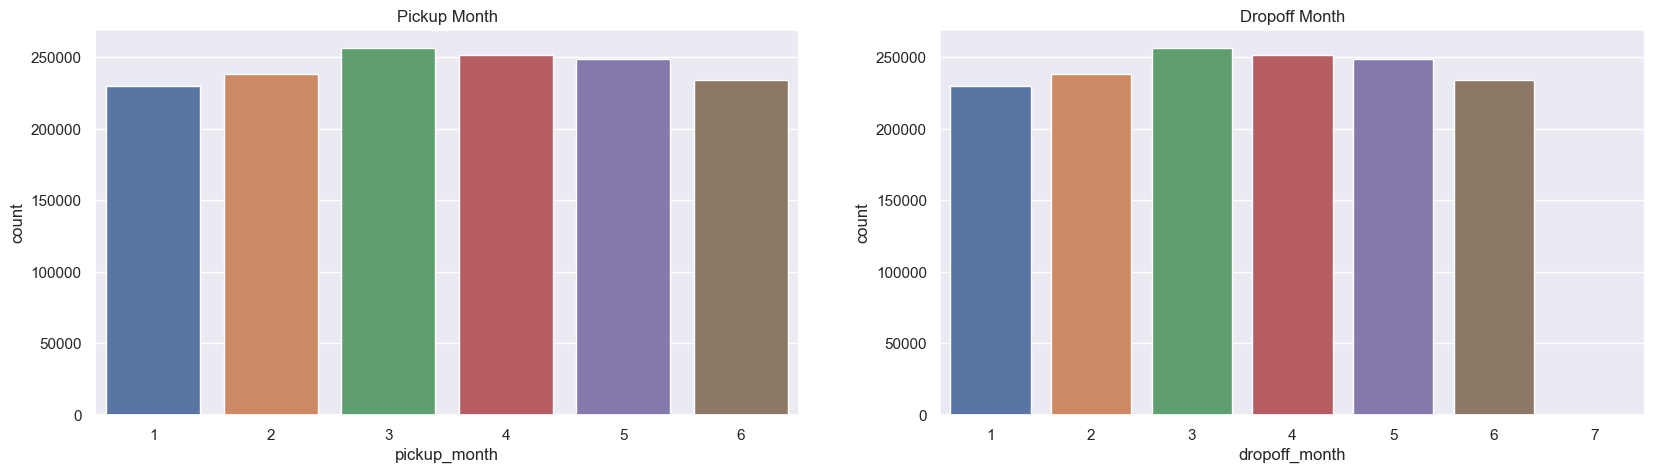

In [30]:
figure,(ax11,ax12)=plt.subplots(ncols=2,figsize=(20,5))
ax11.set_title('Pickup Month')
ax=sns.countplot(x="pickup_month",data=df,ax=ax11)
ax12.set_title('Dropoff Month')
ax=sns.countplot(x="dropoff_month",data=df,ax=ax12)

<Axes: xlabel='pickup_month', ylabel='trip_duration'>

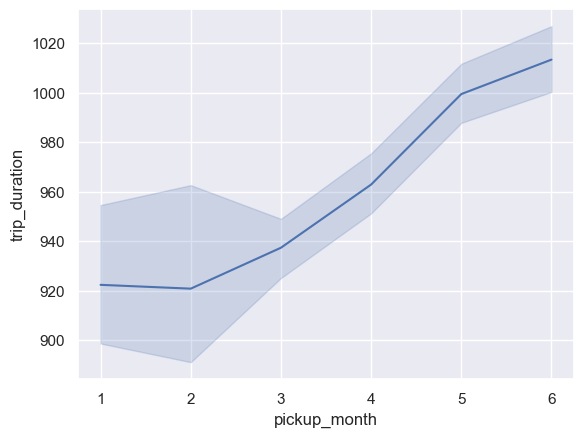

In [31]:
sns.lineplot(x='pickup_month', y='trip_duration', data=df)

## Temperature

In [32]:
df = df_raw[df_raw['trip_duration']<(24*60*60)].copy()
df['time'] = pd.to_datetime(df['pickup_datetime']).apply(lambda x: x.replace(minute=0, second=0, microsecond=0))
df = df.merge(df_weather[['time', 'temp', 'dwpt', 'rhum', 'prcp', 'snow', 'wspd']], how='left', on=['time'])

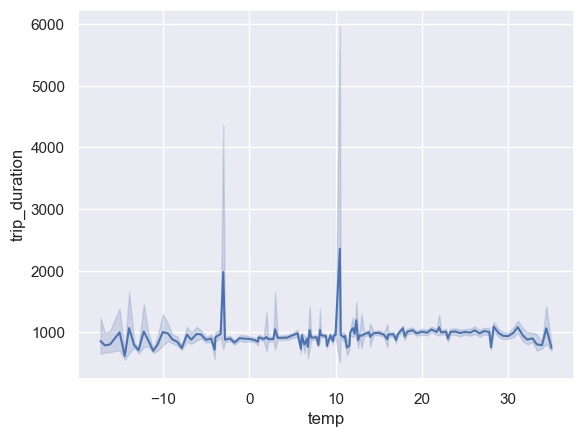

In [33]:
sns.lineplot(x='temp', y='trip_duration', data=df)
plt.show()

## Precipitation

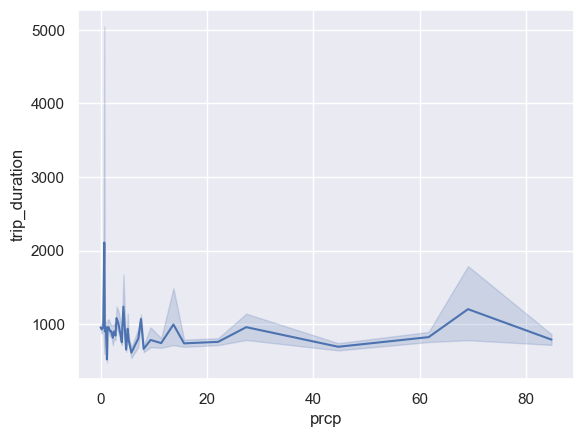

In [34]:
sns.lineplot(x='prcp', y='trip_duration', data=df)
plt.show()

## Snow Depth

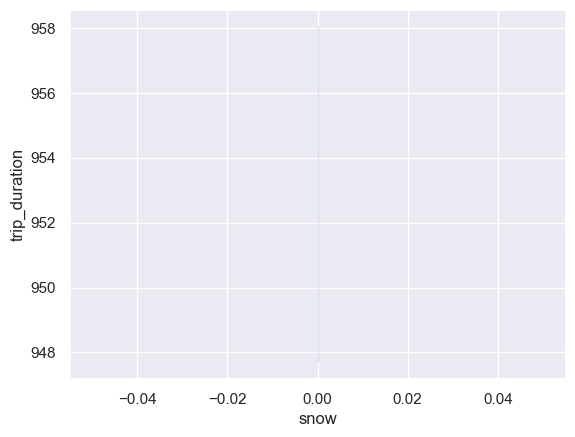

In [35]:
sns.lineplot(x='snow', y='trip_duration', data=df)
plt.show()

## WindSpeed

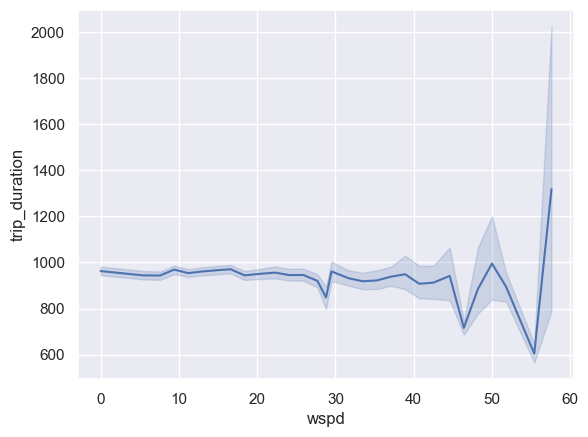

In [36]:
sns.lineplot(x='wspd', y='trip_duration', data=df)
plt.show()

## Correlation

In [37]:
df = df_raw.copy()

df['distance'] = df.apply(lambda x: cal_distance(x['pickup_latitude'],x['pickup_longitude'],
                                                 x['dropoff_latitude'],x['dropoff_longitude']), axis=1)

df['avg_speed'] = round(df['distance']/(df['trip_duration']/(60*60)), 2)

df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])
df['dropoff_datetime'] = pd.to_datetime(df['dropoff_datetime'])

# df['pickup_day']=df['pickup_datetime'].dt.day_name()
# df['dropoff_day']=df['dropoff_datetime'].dt.day_name()
df['pickup_day_no']=df['pickup_datetime'].dt.weekday
# df['dropoff_day_no']=df['dropoff_datetime'].dt.weekday
df['pickup_hour']=df['pickup_datetime'].dt.hour
df['dropoff_hour']=df['dropoff_datetime'].dt.hour
df['pickup_month']=df['pickup_datetime'].dt.month
# df['dropoff_month']=df['dropoff_datetime'].dt.month

def time_of_day(x):
    if x in range(6,12):
        return 'Morning'
    elif x in range(12,16):
        return 'Afternoon'
    elif x in range(16,22):
        return 'Evening'
    else:
        return 'Latenight'
    
df['pickup_timeofday']=df['pickup_hour'].apply(time_of_day)
# df['dropoff_timeofday']=df['dropoff_hour'].apply(time_of_day)

df['time'] = pd.to_datetime(df['pickup_datetime']).apply(lambda x: x.replace(minute=0, second=0, microsecond=0))
df = df.merge(df_weather[['time', 'temp', 'dwpt', 'rhum', 'prcp', 'wspd']], how='left', on=['time'])

In [38]:
print(df.shape)
df_1 = df[(df['trip_duration']<(24*60*60))]
print(df_1.shape)
df_2 = df_1[(df_1['trip_duration']>(10))]
print(df_2.shape)
df_3 = df_2[~df_2['passenger_count'].isin([0, 7, 8, 9])]
print(df_3.shape)
df_4 = df_3[df_3['distance']<100]
print(df_4.shape)
df_5 = df_4[df_4['distance']!=0]
print(df_5.shape)
df_6 = df_5[df_5['avg_speed']<100]
print(df_6.shape)
df_7 = df_6[df_6['avg_speed']>1]
print(df_7.shape)

(1458644, 21)
(1458640, 21)
(1456474, 21)
(1456433, 21)
(1456420, 21)
(1451216, 21)
(1451186, 21)
(1442134, 21)


In [39]:
print(df.shape[0]-df_7.shape[0], round(100*df_7.shape[0]/df.shape[0], 2))

16510 98.87


In [40]:
df_trip = df_7.drop(columns=['pickup_datetime','dropoff_datetime', 'time', 'avg_speed', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',]).copy()

df_trip = pd.get_dummies(df_trip, columns=["pickup_timeofday", 'pickup_day_no'], dtype=float)
df_trip.head()

,passenger_count,trip_duration,distance,pickup_hour,dropoff_hour,pickup_month,temp,dwpt,rhum,prcp,wspd,pickup_timeofday_Afternoon,pickup_timeofday_Evening,pickup_timeofday_Latenight,pickup_timeofday_Morning,pickup_day_no_0,pickup_day_no_1,pickup_day_no_2,pickup_day_no_3,pickup_day_no_4,pickup_day_no_5,pickup_day_no_6
0,1,455,0.931139,17,17,3,6.7,5.0,89.0,2.5,20.5,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,663,1.121892,0,0,6,31.7,19.3,48.0,0.0,18.4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,1,2124,3.967522,11,12,1,-8.9,-16.8,53.0,0.0,24.1,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,1,429,0.923047,19,19,4,8.9,-6.1,34.0,0.0,27.7,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,1,435,0.738556,13,13,3,5.6,-2.7,55.0,0.0,18.4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [42]:
sc = StandardScaler()
X = sc.fit_transform(df_trip)
df_trip = pd.DataFrame(X, columns=df_trip.columns)
df_trip.head()

,passenger_count,trip_duration,distance,pickup_hour,dropoff_hour,pickup_month,temp,dwpt,rhum,prcp,wspd,pickup_timeofday_Afternoon,pickup_timeofday_Evening,pickup_timeofday_Latenight,pickup_timeofday_Morning,pickup_day_no_0,pickup_day_no_1,pickup_day_no_2,pickup_day_no_3,pickup_day_no_4,pickup_day_no_5,pickup_day_no_6
0,-0.505764,-0.568082,-0.498516,0.529534,0.523707,-0.307270,-0.466569,0.363943,1.602564,0.961632,0.484928,-0.497324,1.405310,-0.531662,-0.569949,2.603588,-0.401868,-0.410345,-0.419773,-0.425369,-0.422391,-0.393117
1,-0.505764,-0.260625,-0.420844,-2.127319,-2.098963,1.477628,2.153291,1.819926,-0.344053,-0.076948,0.263057,-0.497324,-0.711587,1.880895,-0.569949,-0.384085,-0.401868,-0.410345,-0.419773,-0.425369,-0.422391,2.543770
2,-0.505764,1.898968,0.737864,-0.408179,-0.247667,-1.497202,-2.101361,-1.855667,-0.106660,-0.076948,0.865278,-0.497324,-0.711587,-0.531662,1.754543,-0.384085,2.488382,-0.410345,-0.419773,-0.425369,-0.422391,-0.393117
3,-0.505764,-0.606514,-0.501811,0.842105,0.832256,0.287696,-0.236021,-0.766226,-1.008751,-0.076948,1.245628,-0.497324,1.405310,-0.531662,-0.569949,-0.384085,-0.401868,2.436974,-0.419773,-0.425369,-0.422391,-0.393117
4,-0.505764,-0.597645,-0.576934,-0.095608,-0.093392,-0.307270,-0.581843,-0.420048,-0.011703,-0.076948,0.263057,2.010763,-0.711587,-0.531662,-0.569949,-0.384085,-0.401868,-0.410345,-0.419773,-0.425369,2.367474,-0.393117


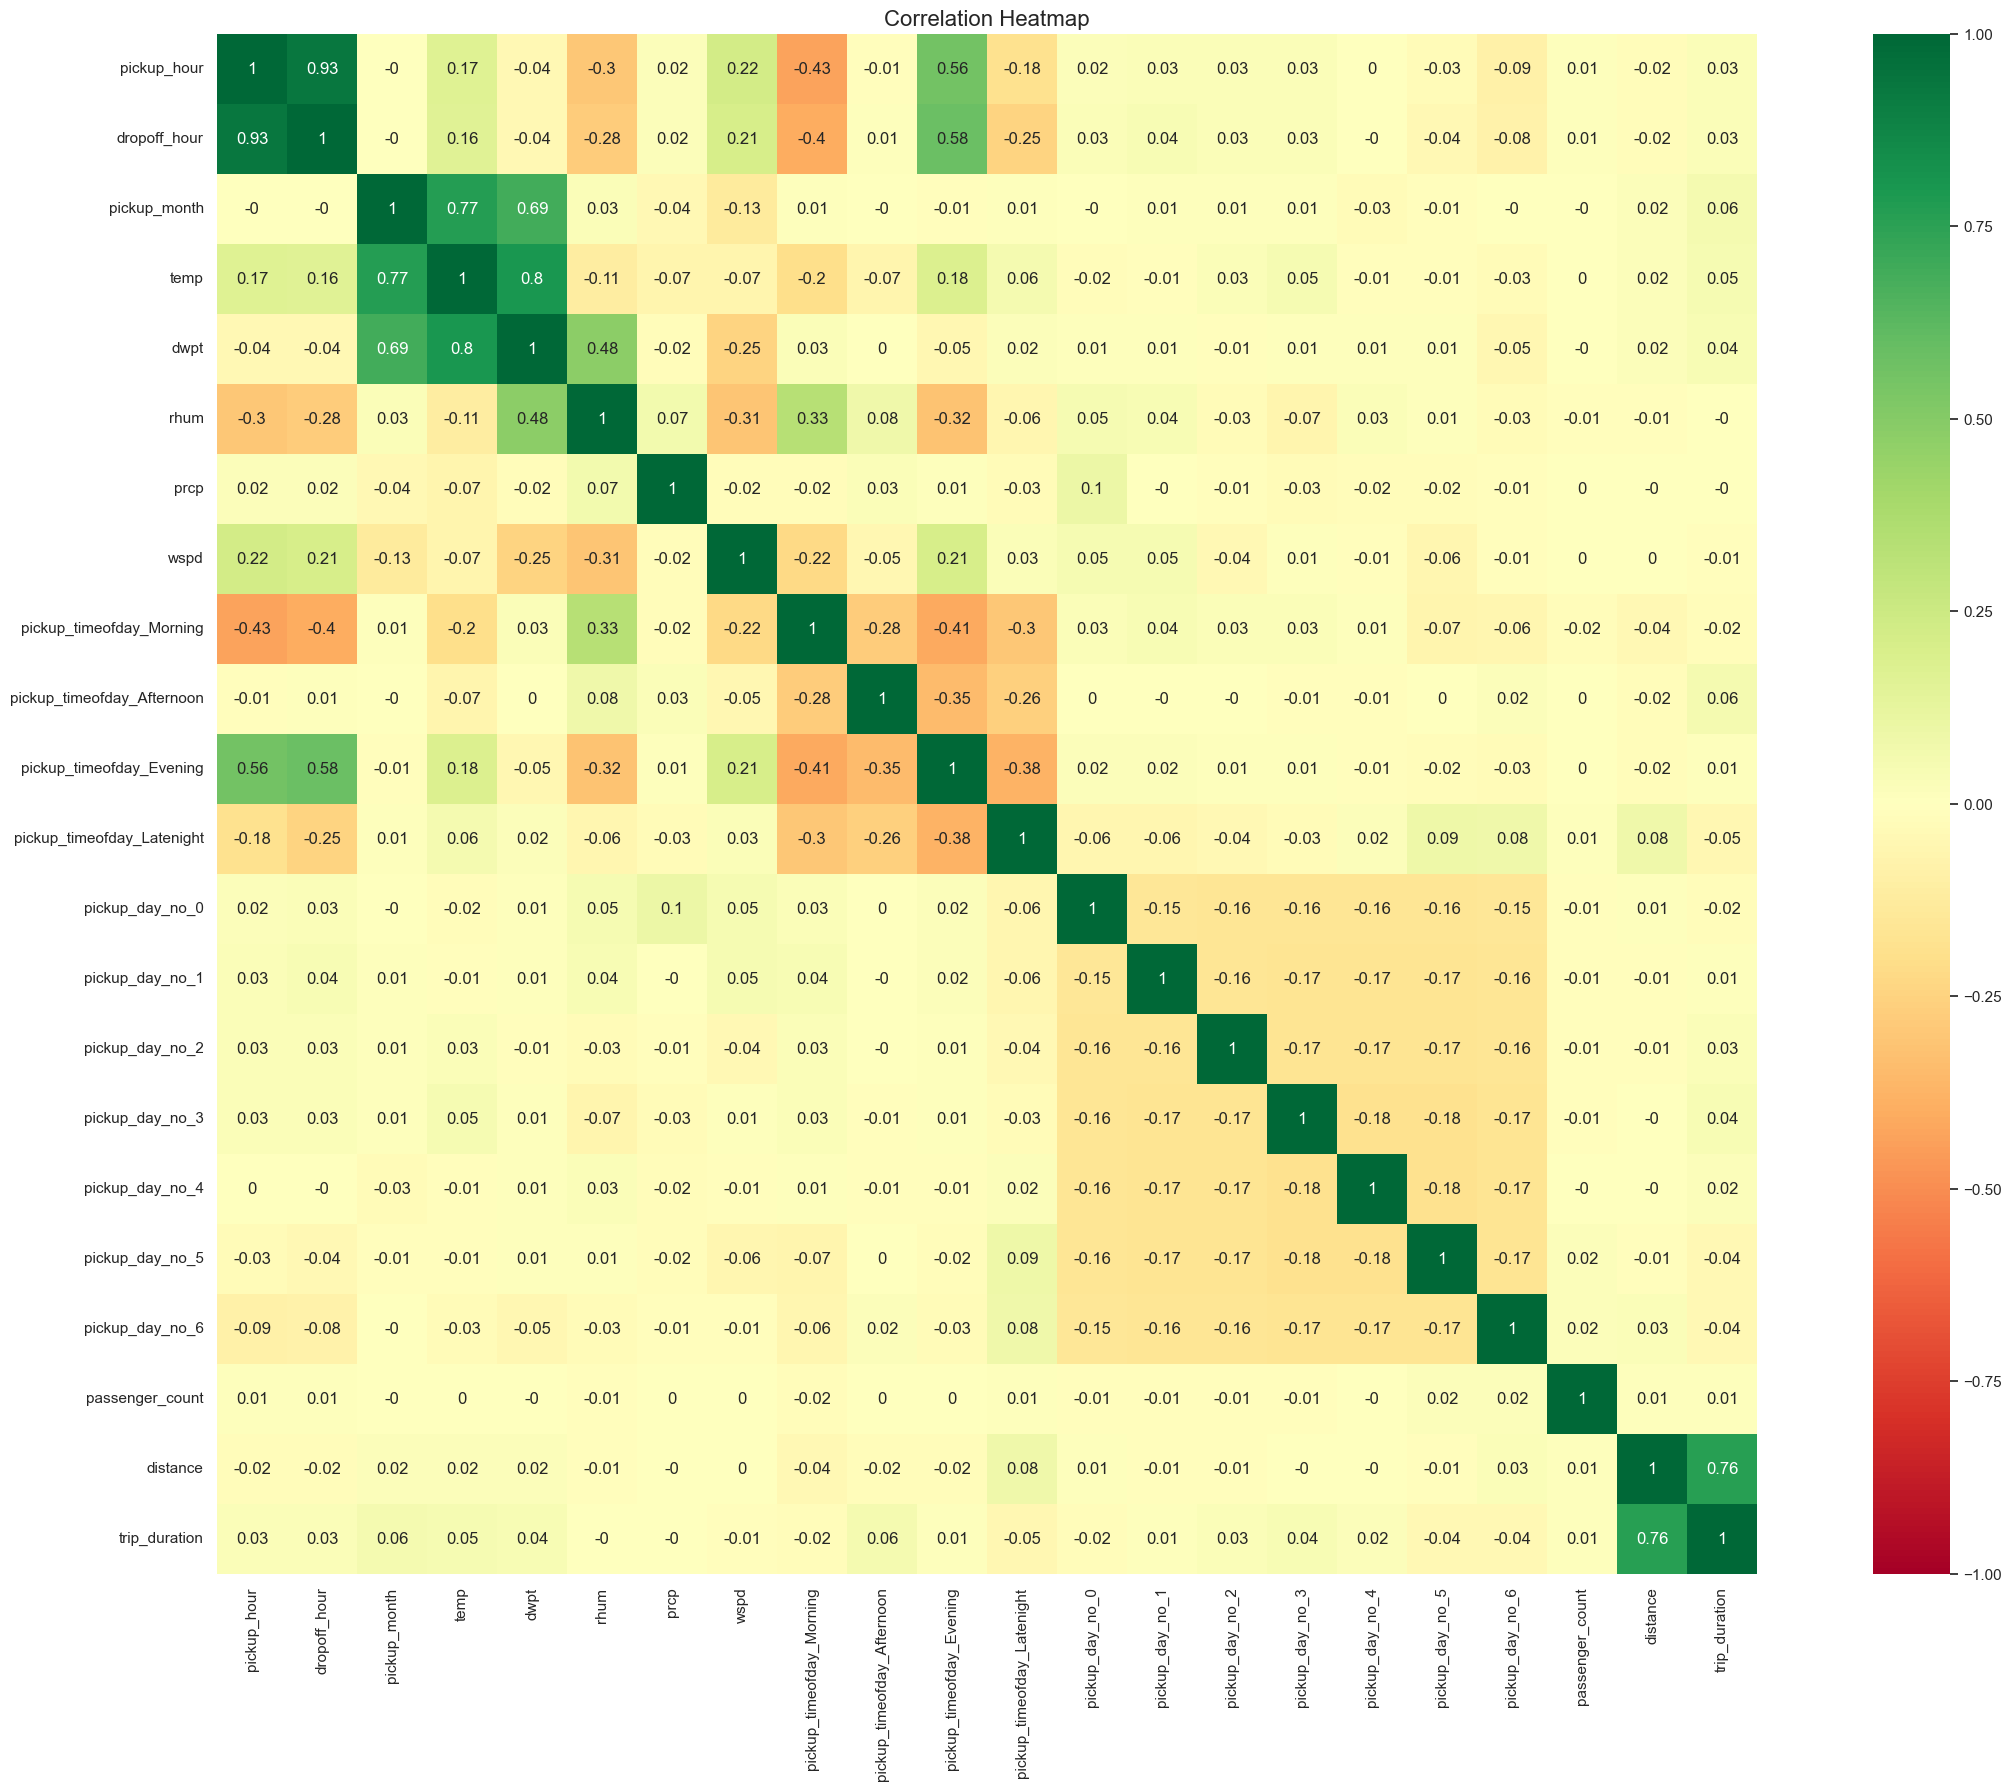

In [43]:
plt.figure (figsize= (30,20))

df_corr = df_trip[['pickup_hour', 'dropoff_hour', 'pickup_month', 'temp', 'dwpt', 'rhum', 'prcp', 'wspd', 
                   'pickup_timeofday_Morning', 'pickup_timeofday_Afternoon', 'pickup_timeofday_Evening', 
                   'pickup_timeofday_Latenight', 'pickup_day_no_0', 'pickup_day_no_1', 'pickup_day_no_2', 'pickup_day_no_3',
                   'pickup_day_no_4', 'pickup_day_no_5', 'pickup_day_no_6','passenger_count', 'distance', 'trip_duration',]].corr().round(2)


sns.heatmap(df_corr, cmap='RdYlGn', annot=True, vmin=-1, vmax=1, square=True)
plt.title("Correlation Heatmap", fontsize=16)
plt.show()

In [41]:
del df_raw,df,df_1,df_2,df_3,df_4,df_5,df_6,df_7, df_corr

# Feature Selection

In [44]:
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestRegressor

In [45]:
X = df_trip.drop(columns=['trip_duration'])
y = df_trip['trip_duration']

In [ ]:
estimator = RandomForestRegressor()
selector = RFE(estimator)
selector = selector.fit(X, y)

In [46]:
cols = ['passenger_count', 'distance', 'pickup_hour', 'dropoff_hour', 'pickup_month', 'temp', 'dwpt', 'rhum', 'wspd', 'pickup_timeofday_Latenight']

In [47]:
del X, y

# Modelling

In [48]:
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

In [49]:
from matplotlib import legend
from sklearn.metrics import r2_score, mean_squared_error

# Function for evaluation metric for regression
def EvaluationMetric(yt, yp, shp=1, n=2):
    MSE = round(mean_squared_error(y_true=yt,y_pred=yp),4)
    RMSE=round((np.sqrt(MSE)), 4)
    R2= round((r2_score(y_true=yt,y_pred=yp)), 4)
    Adjusted_R2= round(1-((1-R2)*(shp-1))/(shp-n-1), 4)
    
    print("MSE :", MSE, "RMSE :", RMSE)
    print("R2 :", R2, "Adjusted R2 :", Adjusted_R2)

    #Plotting Actual and Predicted Values
    plt.figure(figsize=(18,6))
    plt.plot((np.array(yt[:100])))
    plt.plot((yp[:100])) 
    plt.legend(["Actual","Predicted",])
    plt.title('Actual and Predicted Time Duration')

In [50]:
from sklearn.model_selection import train_test_split 

df_data = df_trip[cols+['trip_duration']].head(50000)

X = df_data.drop(columns=['trip_duration'])
y = df_data['trip_duration']

In [51]:
X_train, X_test, y_train, y_test = train_test_split(df_trip[cols], df_trip[['trip_duration']], random_state=7, test_size=0.33, shuffle=True) 

## Linear Regression

In [52]:
model = LinearRegression()
params = {'fit_intercept':[True, False],'positive':[True, False], 'n_jobs':[-1]}

clf =  GridSearchCV(model, params, cv=5, return_train_score=False, verbose=2)
clf.fit(X, y)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV] END .......fit_intercept=True, n_jobs=-1, positive=True; total time=   0.0s
[CV] END .......fit_intercept=True, n_jobs=-1, positive=True; total time=   0.0s
[CV] END .......fit_intercept=True, n_jobs=-1, positive=True; total time=   0.0s
[CV] END .......fit_intercept=True, n_jobs=-1, positive=True; total time=   0.0s
[CV] END .......fit_intercept=True, n_jobs=-1, positive=True; total time=   0.0s
[CV] END ......fit_intercept=True, n_jobs=-1, positive=False; total time=   0.0s
[CV] END ......fit_intercept=True, n_jobs=-1, positive=False; total time=   0.0s
[CV] END ......fit_intercept=True, n_jobs=-1, positive=False; total time=   0.0s
[CV] END ......fit_intercept=True, n_jobs=-1, positive=False; total time=   0.0s
[CV] END ......fit_intercept=True, n_jobs=-1, positive=False; total time=   0.0s
[CV] END ......fit_intercept=False, n_jobs=-1, positive=True; total time=   0.0s
[CV] END ......fit_intercept=False, n_jobs=-1, po

GridSearchCV(cv=5, estimator=LinearRegression(),
             param_grid={'fit_intercept': [True, False], 'n_jobs': [-1],
                         'positive': [True, False]},
             verbose=2)

In [53]:
print(clf.best_params_, round(clf.best_score_, 4))

{'fit_intercept': True, 'n_jobs': -1, 'positive': False} 0.6057


In [54]:
model = LinearRegression(**clf.best_params_)
model.fit(X_train, y_train)

LinearRegression(n_jobs=-1)

MSE : 0.4015 RMSE : 0.6336
R2 : 0.5938 Adjusted R2 : 0.5938


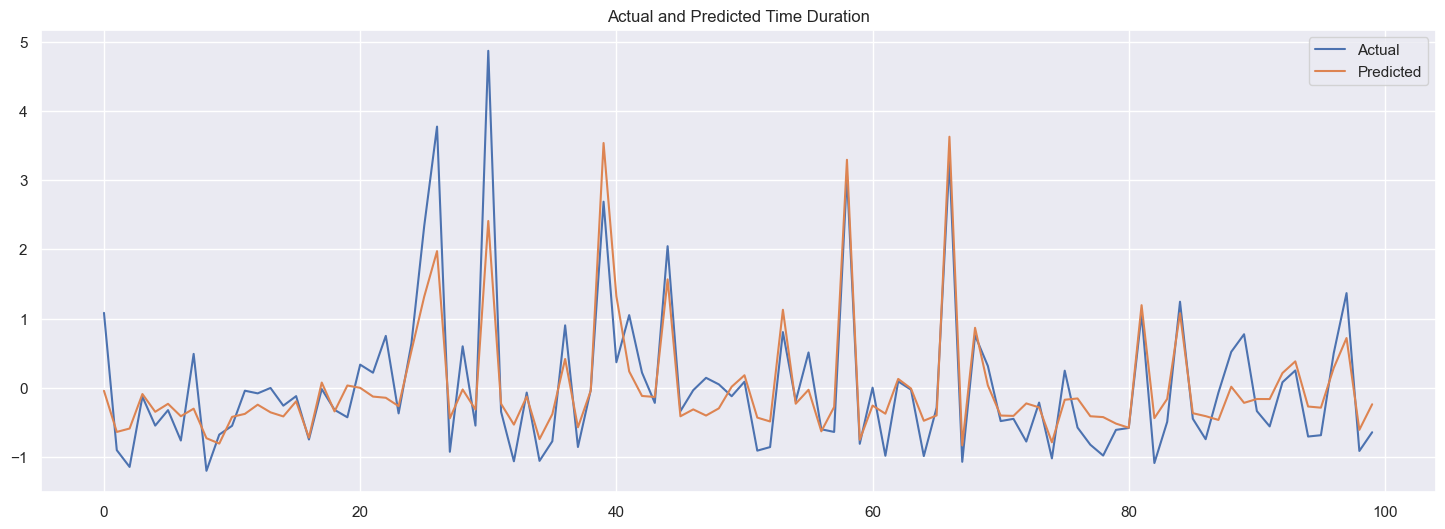

In [55]:
y_pred = model.predict(X_test)
EvaluationMetric(y_test, y_pred, shp=X_test.shape[0], n=X_test.shape[1])

## Random Forest

In [56]:
model = RandomForestRegressor(n_jobs=-1)
params = {
    'n_estimators': [100,1000],
    'max_depth': [6, 9, 12],
    #       'min_samples_leaf': [100,200,300,500,1000],
          # 'criterion' : ['absolute_error', 'squared_error'], 
    'n_jobs':[-1]}

clf =  GridSearchCV(model, params, cv=2, return_train_score=False, verbose=2)
clf.fit(X, y)

Fitting 2 folds for each of 2 candidates, totalling 4 fits
[CV] END ........................n_estimators=100, n_jobs=-1; total time=  12.7s
[CV] END ........................n_estimators=100, n_jobs=-1; total time=   9.4s
[CV] END .......................n_estimators=1000, n_jobs=-1; total time= 1.6min
[CV] END .......................n_estimators=1000, n_jobs=-1; total time= 1.6min


GridSearchCV(cv=2, estimator=RandomForestRegressor(n_jobs=-1),
             param_grid={'n_estimators': [100, 1000], 'n_jobs': [-1]},
             verbose=2)

In [57]:
print(clf.best_params_, round(clf.best_score_, 4))

{'n_estimators': 1000, 'n_jobs': -1} 0.6896


In [ ]:
model = RandomForestRegressor(n_estimators=1000, n_jobs=-1)
model.fit(X_train, y_train)

In [ ]:
y_pred = model.predict(X_test)
EvaluationMetric(y_test, y_pred, shp=X_test.shape[0], n=X_test.shape[1])

## XGBoost

In [ ]:
model = XGBRegressor()
params = {'n_estimators': [1,5,10,100, ],
          'max_depth': [1,2,3,4,5,6],
          'min_samples_leaf': [100,200,300,500,1000],
          'learning_rate ' : [0.01, 0.1, 0.5, 0.75, 1], 
          "gamma":[ 0.0, 0.1, 0.2],
          'n_jobs':[-1]
         }

clf =  GridSearchCV(model, params, cv=2, return_train_score=False, scoring='neg_mean_squared_error', verbose=3, n_jobs=-1)
clf.fit(X_selected, y)

In [ ]:
clf.best_params_

In [ ]:
model = XGBRegressor(**clf.best_params_)
model.fit(X_train, y_train)

In [ ]:
y_pred = model.predict(X_test)

In [ ]:
EvaluationMetric(y_test, y_pred, shp=X_test.shape[0], n=12)

## LightGBM

In [ ]:
model = LGBMRegressor()
model.fit(X_train, y_train)

In [ ]:
y_pred = model.predict(X_test)

In [ ]:
EvaluationMetric(y_test, y_pred, shp=X_test.shape[0], n=12)